# Cassava Leaf Disease Classification Challenge with Tensorflow-Keras :
---

This notebook holds complete interpretation of Cassva Leaf Disease Classification Challenge using Keras Tensorflow.

The notebook has been run on kaggle kernels, so if you are running this in your system and have already downloaded the file then do some basic preprocessing and you're good to go. **:)**

Data folder has a specific tree structure -


         cassava-leaf-disease-classification/
                                     -train_images/
                                            -image1.jpg
                                            -image2.jpg
                                            .
                                            .
                                     -test_images/
                                            -image1.jpg
                                     -train.csv
                                     -sample_submission.csv

In [1]:
# Directories
train_root = '../input/cassava-leaf-disease-classification/train_images'
test_root = '../input/cassava-leaf-disease-classification/test_images'

In [2]:
# Importaed basic data directory manipulation libraries
import os
from glob import glob

In [3]:
# Number of Image in Each folder
print(f'Image in train data : {len(os.listdir(train_root))}')
print(f'Image in test data : {len(os.listdir(test_root))}')

Image in train data : 21397
Image in test data : 1


In [4]:
# Imported Basic Data Manipulation Libraries
import numpy as np
import pandas as pd

In [5]:
# Loading Train dataset
train_df = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


Let us see and set the actual classes in the dataset , which will be used in data generating.

In [6]:
# Read classes from json file
import json
json_file_path = '../input/cassava-leaf-disease-classification/label_num_to_disease_map.json'
class_df = pd.read_json(json_file_path ,lines=True).T
class_df

,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


In [7]:
# Classes
class_df.columns = ['labels']
class_df

,labels
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


In [8]:
classes = np.array(class_df['labels'])
classes

array(['Cassava Bacterial Blight (CBB)',
       'Cassava Brown Streak Disease (CBSD)',
       'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)',
       'Healthy'], dtype=object)

In [9]:
# Classes added to the train datframe
class_col = []

for i in train_df['label']:
    class_col.append(classes[i])
    
train_df['class'] = class_col

train_df.head()

,image_id,label,class
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)


The train data folder has no specific subdirectory for setting the classes of every single image. So, we are going to use the labels on the dataframe to generate the tensor dataset which will be trained on our Neural Network Model.

In [10]:
# Imported Neural Network and dataset making libraries
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers

Now we have imported all libraries to work.

As we have some images from different angles , we have to augment the image so that we can have a less biased dataset.

In this augment process the images should also be normalized to the values between 0 and 1 . This would help the model dodge unwanted maximas.

In [11]:
augment = ImageDataGenerator(
             # validation split is specified which is 85-15 train-val split
            validation_split = 0.15,
            # augmenting vertical and horizontal flips
            vertical_flip = True,
            horizontal_flip = True,
            # rescaling the image data 
            rescale = 1./255
)

Now the data augment has been set , select the hyperparameters and form the datsets.

In [12]:
# Hyperparameters
SEED = 42
BATCH_SIZE = 50
HEIGHT = 256
WIDTH = 256
general_path = '../input/cassava-leaf-disease-classification/'

In [13]:
# Dataset Generator
train_data = augment.flow_from_dataframe(
    dataframe=train_df,
    directory=general_path + 'train_images',
    x_col='image_id',
    y_col='class',
    target_size = (HEIGHT , WIDTH),
    batch_size = BATCH_SIZE,
    subset='training',
    seed=42
)

val_data = augment.flow_from_dataframe(
    dataframe=train_df,
    directory=general_path + 'train_images',
    x_col='image_id',
    y_col='class',
    target_size = (HEIGHT , WIDTH),
    batch_size = BATCH_SIZE,
    subset='validation',
    seed=42
)

Found 18188 validated image filenames belonging to 5 classes.
Found 3209 validated image filenames belonging to 5 classes.


We can see the data has 5 classes. Let's see what are those and validate if the classes are set accordingly.

In [14]:
train_data.class_indices

{'Cassava Bacterial Blight (CBB)': 0,
 'Cassava Brown Streak Disease (CBSD)': 1,
 'Cassava Green Mottle (CGM)': 2,
 'Cassava Mosaic Disease (CMD)': 3,
 'Healthy': 4}

The labels are perfect. The datageneration process has been completed . Now we are going build the model and train on the dataset.

 In this problem I have chosen the model EfficientNetB7 as it gives the best accuracy on [ImageNet](https://www.image-net.org/) dataset.
 Now we are using the pretrained weights and customize the bottom layers , so that we might train our required data on the model.
 
The input layer is also getting tampered as per our use.

In [15]:
model = EfficientNetB7(include_top = False , input_tensor = layers.Input(shape=(256,256,3)))
model.summary()

Now setting all the model layers as non trainable layers. As we want to use the pretrained weights rom the model, so we are only going to update the last layer's weights.

Now, this updated model will be trained over our dataset.

In [16]:
for layer in model.layers:
  layer.trainable = False


# Now adding the last layers which are going to get trained 


effb7_output = model.output
fl_layer = layers.Flatten()(effb7_output)
d1_layer = layers.Dense(4096,activation='relu')(fl_layer)
d2_layer = layers.Dense(4096,activation='relu')(d1_layer)
output = layers.Dense(5,activation='softmax')(d2_layer)


# Creating the custom model from VGG19 pretrained Network
clf = keras.models.Model(inputs = model.input , outputs = output)
clf.summary()

Let us validate layers trainablity.

In [17]:
for layer in clf.layers:
    print(layer.trainable,end=" ")

False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fals

Okay. The model is ready. Now coompiling it for model updation.

In [18]:
# Compile the model
clf.compile(
optimizer = 'adam',
loss = 'categorical_crossentropy',
metrics = ['accuracy']
)

In [19]:
# setting callbacks to redue overfitting. 

"""
Note that :

In this tutorial we are not settiing the 
patience and thus the model is getting stopped 
at epoch 2. This is happen due to local minima problem.

"""
callbacks = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights = True,
)

Setting epochs and verbose as they are hyperparameters.

In [20]:
EPOCHS = 20
VERBOSE = 1

Now, we have reached the most important part of the whole tutorial. 
The model is getting trained over the data itself.

In [21]:
history = clf.fit(
    train_data ,
    epochs = EPOCHS ,
    batch_size = BATCH_SIZE ,
    validation_data = val_data,
    callbacks = [callbacks],
    verbose = VERBOSE
)

Epoch 1/20
364/364 [==============================] - 381s 992ms/step - loss: 42.7661 - accuracy: 0.5077 - val_loss: 1.1737 - val_accuracy: 0.6183
Epoch 2/20
364/364 [==============================] - 268s 736ms/step - loss: 1.2975 - accuracy: 0.6033 - val_loss: 1.1839 - val_accuracy: 0.6183


Now as said before the model is stuck in any local minima and early stopping preventing the model to go forwad , we will use this model to predcit over the test data.

In [22]:
import cv2

In [23]:
import matplotlib.pyplot as plt

We have only 1 test image to predict. Before predicting let us visualize it.

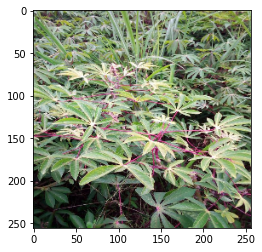

In [24]:
test_image = cv2.imread('../input/cassava-leaf-disease-classification/test_images/2216849948.jpg')
test_image = cv2.cvtColor(test_image , cv2.COLOR_BGR2RGB)
test_image = cv2.resize(test_image , (HEIGHT , WIDTH))
plt.imshow(test_image)
plt.show()

Now, predicting the test image.

In [25]:
prediction = clf.predict(test_image.reshape(1,HEIGHT,WIDTH,3))

print(prediction)

[[0.02978932 0.12584874 0.18918727 0.5220921  0.13308258]]


In [26]:
index1 = np.argmax(prediction)

In [27]:
# Predicted class :
print(f'Predicted class of the image : {classes[index1]}')

Predicted class of the image : Cassava Mosaic Disease (CMD)


Creating the submission dataframe and thus creating teh submission file.

In [28]:
submission_df = pd.DataFrame({
    'image_id' : ['2216849948.jpg'],
    'label' : [index1]
})
submission_df

,image_id,label
0,2216849948.jpg,3


In [29]:
submission_df.to_csv('submission.csv',index=False)

## Thank You for visiting. Do visit my other works in [kaggle](https://kaggle.com/sagnik1511) and in [github](https://github.com/sagnik1511)


# Do Upvote if found useful :)